In [1008]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.linalg import logm, expm

from ncpol2sdpa import generate_variables, SdpRelaxation

from qutip import sigmax, sigmay, sigmaz, propagator, tensor, Qobj

from sympy import Matrix, eye, diag, Float, Rational, symbols, I, re, sin, lambdify, integrate, sympify

from sympy.matrices import randMatrix, matrix2numpy

from sympy.physics.quantum import TensorProduct, Commutator

In [14]:
sx = Matrix(sigmax())

In [463]:
expm(1j * np.array(sigmax()))

array([[0.54030231+0.j        , 0.        +0.84147098j],
       [0.        +0.84147098j, 0.54030231+0.j        ]])

In [17]:
a = tensorproduct(sx, eye(2))

In [19]:
a.is_Matrix

False

The function generating 
$N\Delta t \left[\hat{1} \otimes \hat{H}_0 + u((\hat{T} + \hat{1}/2) \Delta t ) \otimes \hat{V}\right]$

In [434]:
def control_gen(*, H0, V, N, dt, u, **kwargs):
    
    # Evaluate u((\hat{T} + \hat{1}/2) \Delta t )
    u_term = diag(*(
        u(dt * (k +  Rational(1, 2))) for k in range(N)
    ))
        
    return N * dt * (TensorProduct(eye(N), H0) + TensorProduct(u_term, V))

The cost function to be minimized 
$\left\| N\Delta t \left[\hat{1} \otimes \hat{H}_0 + u((\hat{T} + \hat{1}/2) \Delta t ) \otimes \hat{V}\right] + \hat{1} \otimes \hat{G}\right\|_F^2 \to \min.$

In [484]:
def J(*, N, G, **kwargs):
    return (
        control_gen(N=N, **kwargs) + TensorProduct(eye(N), G)
    ).norm() ** 2

In [485]:
def MatrixJ(*, N, G, **kwargs):
    return        control_gen(N=N, **kwargs) + TensorProduct(eye(N), G)
    

In [486]:
def expm_control_gen(*, N, G, **kwargs):
    return (-1j * control_gen(N=N, **kwargs)).exp().evalf()

In [490]:
def expG(*, N, G, **kwargs):
    return TensorProduct(eye(N), (1j * G).exp()).evalf()

# Example

In [838]:
H0 = randMatrix(4, percent=100) + I * randMatrix(4, percent=80)
H0 = H0.H + H0

V = randMatrix(4, percent=100) + I * randMatrix(4, percent=80)
V = V.H + V

sys_params = dict(
    H0 = H0,
    V = V,
        
    dt = Rational(1, 10),
    N = 10,
)

H0 = Qobj(matrix2numpy(sys_params['H0']))
V = Qobj(matrix2numpy(sys_params['V']))

In [840]:
U = propagator([H0, [V, 't ** 2']], 4)

In [843]:
sys_params['G'] = Matrix(np.around(logm(U), 4) / 1j)

In [844]:
sys_params['G']

Matrix([
[           0.7528, -0.3401 - 0.4321*I,  -0.428 - 1.0452*I,  0.0113 + 0.3432*I],
[-0.3401 + 0.432*I,            -0.6011, -0.7467 + 0.2925*I, -1.2395 + 0.5125*I],
[-0.428 + 1.0451*I, -0.7467 - 0.2924*I,            -0.0009,  -0.8962 + 1.272*I],
[0.0113 - 0.3432*I, -1.2395 - 0.5125*I, -0.8963 - 1.2721*I,            -0.0326]])

In [845]:
(obj)

266.682*x0**2 + 266.682*x0*x1 + 177.34353*x0*x2 + 395.507844*x0 + 88.671765*x1**2 + 132.674295*x1*x2 + 197.753922*x1 - 4.99600361081321e-16*I*x1 + 52.8927078225*x2**2 + 131.50635813*x2 - 4.99600361081321e-16*I*x2 + 240.323434188

In [846]:
x = generate_variables('x', 3)

obj = J(u=lambda t: x[0] + x[1] * t + x[2] * t ** 2, **sys_params).simplify()

sdp = SdpRelaxation(x)
sdp.get_relaxation(8, objective=re(obj))
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    print([sdp[_] for _ in sdp.variables])

[-0.6482934195176792, 3.693863442391718e-08, 2.6555582661506082e-08]


In [847]:
Un = propagator(
    [H0, 
    #[V, '1.2106486632912106 * t -1.0164572106234302 * t * t']],
     [V, '-0.6482934195176792']],
    4
)


In [848]:
(Un - U).norm()

5.395916941146283

In [822]:
U.norm()

3.9999999999998366

In [742]:
Un.norm()

3.9999999999999956

In [765]:
sys_params['G']

Matrix([
[             -0.2114,  -0.2135 - 0.08872*I, -0.58334 - 0.20692*I, -0.28785 - 0.14271*I],
[ -0.2135 + 0.08872*I,             -0.38259,    0.0483 + 0.1738*I, -0.81116 - 0.00155*I],
[-0.58334 + 0.20692*I,   0.0483 - 0.17379*I,             -0.81325, -0.65112 + 0.02163*I],
[-0.28785 + 0.14272*I, -0.81116 + 0.00155*I, -0.65112 - 0.02163*I,             -1.02695]])

In [767]:
Matrix(np.around(logm(Un), 5) / 1j)

Matrix([
[-0.04192,    -0.22, -0.52251,  -0.1767],
[   -0.22, -0.39275,        0, -0.87575],
[-0.52251,        0, -0.96071, -0.70856],
[ -0.1767, -0.87575, -0.70856, -1.05964]])

In [723]:
Un

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.82344125-0.13371235j -0.09627055-0.06197975j -0.29435129-0.40008505j
  -0.20137559+0.06077131j]
 [-0.09627055-0.06197975j  0.54415338-0.74110819j -0.19945144+0.05067774j
  -0.25107518-0.19015358j]
 [-0.29435128-0.40008504j -0.19945144+0.05067774j  0.32640483-0.51100513j
  -0.43763869-0.38954611j]
 [-0.20137559+0.06077131j -0.25107518-0.19015358j -0.43763869-0.38954611j
   0.62011482-0.35880552j]]

# Example 2

In [980]:
def get_random_matrix(n):
    H = randMatrix(4, percent=100) + I * randMatrix(4, percent=80)
    H = H.H + H
    
    return H / 200

In [887]:
sys_params_1 = dict(
    H0 = get_random_matrix(4),
    V = get_random_matrix(4),
        
    dt = 1,
    N = 10,
)

sys_params_2 = dict(
    H0 = get_random_matrix(4),
    V = get_random_matrix(4),
        
    dt = 1,
    N = 10,
)

In [959]:
x = generate_variables('x', 4)
t = symbols('t')

obj = (
        (
        control_gen(u = lambda t : 3 * sin(t/2), **sys_params_1) -
        control_gen(u = lambdify(t, sum(c * t ** n for n, c in enumerate(x))), **sys_params_1)
    ).norm() ** 2
).simplify().evalf()

In [1080]:
sdp = SdpRelaxation(x)
sdp.get_relaxation(6, objective=re(obj))
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    opt_vals = [sdp[_] for _ in sdp.variables]
    
    # cover to the function
    t = symbols('t')
    u_reconstructed = lambdify(t, sum(c * t ** n for n, c in enumerate(opt_vals)))
    
    print(u_reconstructed(t))

0.108038547389246*t**3 + 0.0542712973219234*t**2 - 0.151506440572317*t - 0.758672613098914


In [961]:
obj.subs(
    zip(sdp.variables, (sdp[_] for _ in sdp.variables))
).evalf()

82.0271616484970

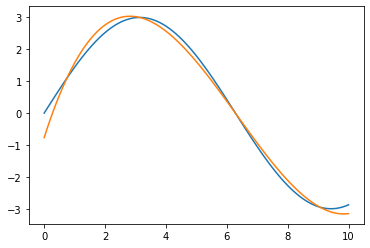

In [962]:
t = np.linspace(0, 10, 100)
plt.plot(t, 3 * np.sin(t/2))
plt.plot(t, np.vectorize(u_reconstructed)(t))

# Magnus expansion

In [1195]:
def magnus_expansion(*, H0, V, u, T, **kwargs):
    
    # symbols
    t1, t2 = symbols('t1, t2', real=True)
    
    
    # introduce alias 
    def h(t):
        return H0 + V * u(t)
    
    def Commutator(a, b):
        return a * b - b * a
    
    
    first_order = -integrate(h(t1), (t1, 0, T))
    
    second_order = -I * Rational(1, 2) * integrate(
        Commutator(integrate(h(t2), (t2, 0, t1)), h(t1)),
        (t1, 0, T)
    )
    
    return first_order + second_order

In [1142]:
sys_params = dict(
    H0 = get_random_matrix(4),
    V = get_random_matrix(4),
    T = 1,
)

H0 = Qobj(matrix2numpy(sys_params['H0']))
V = Qobj(matrix2numpy(sys_params['V']))

Get the target unitary

In [1219]:
u_original_str = '-sin(5 * t)'

U = propagator([H0, [V, u_original_str]], sys_params['T'])

# covert to the numpy function for plotting
t = symbols('t')
u_original = lambdify(t, sympify(u_original_str), 'numpy')

In [1234]:
def smart_extract_generator(U):
    G_exact = logm(U) / 1j
    
    for digit in range(12, 0, -1):
        G_exact_aroud = np.around(G_exact, digit)
        
        if np.alltrue(G_exact_aroud == G_exact_aroud.T.conj()):
            # sucess we got the hermitian matrix
            return G_exact_aroud
    # Take care of SU constrains 

In [1235]:
sys_params['G'] = Matrix(smart_extract_generator(U))
sys_params['G'] 

Matrix([
[             -0.8628,  -0.26779 + 0.0238*I, -0.24266 - 0.00464*I, -0.33647 + 0.18568*I],
[ -0.26779 - 0.0238*I,             -0.46738, -0.01218 + 0.28191*I, -0.45416 - 0.03449*I],
[-0.24266 + 0.00464*I, -0.01218 - 0.28191*I,             -0.60253,  0.07665 - 0.11555*I],
[-0.33647 - 0.18568*I, -0.45416 + 0.03449*I,  0.07665 + 0.11555*I,             -0.69661]])

In [1237]:
x = generate_variables('x', 4)
t = symbols('t', real=True)

u = lambdify(t, sum(c * t ** n for n, c in enumerate(x)))

obj = ((magnus_expansion(u = u, **sys_params) - sys_params['G']).norm() ** 2).simplify()

sdp = SdpRelaxation(x)
sdp.get_relaxation(7, objective=re(obj))
sdp.solve(solver='mosek')

# extract the values of control
if sdp.status == 'optimal':
    opt_vals = [sdp[_] for _ in sdp.variables]
    
    # cover to the function
    t = symbols('t')
    u_reconstructed = sum(c * t ** n for n, c in enumerate(opt_vals))
    
    # Covert u_reconstructed to string for qutip below
    u_reconstructed_str = str(u_reconstructed)
    
    print(u_reconstructed_str)
    
    # u_reconstructed for plotting
    u_reconstructed = lambdify(t, u_reconstructed, 'numpy')

0.691128838639214*t**3 + 0.697933586539568*t**2 + 0.597211429743375*t - 0.855690617008001


In [1238]:
obj.subs(
    zip(sdp.variables, (sdp[_] for _ in sdp.variables))
).evalf()

0.01200205342719 + 1.00173324677832e-19*I

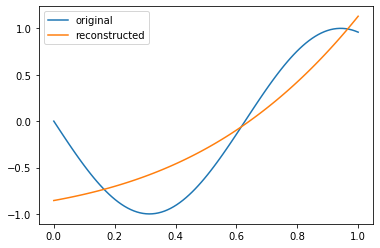

In [1239]:
t = np.linspace(0, sys_params['T'], 100)

plt.plot(t, u_original(t), label='original')
plt.plot(t, u_reconstructed(t), label='reconstructed')
plt.legend()
plt.show()

In [1240]:
Ug = propagator([H0, [V, u_reconstructed_str]], sys_params['T'])

In [1241]:
(Ug - U).norm()

0.02862075596447093

In [1242]:
U - Ug

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[-0.00194197-0.00048605j  0.00219085-0.00527299j  0.00171849-0.00011051j
  -0.00111895-0.00436265j]
 [-0.00820385+0.00516787j -0.00050025-0.00198767j  0.00207988-0.00459082j
  -0.00556593+0.00335048j]
 [-0.00358143+0.00575813j -0.0043606 -0.00192459j -0.0009187 -0.00429642j
  -0.00293716+0.00379659j]
 [-0.00658394+0.00011454j  0.00324537-0.00374507j  0.00215285-0.00041844j
  -0.00320995-0.00263944j]]